In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import sys
import numpy as np
import torch
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import  torch.nn as nn
import torch.nn.functional as F
rseed = 42
np.random.seed(rseed)
torch.manual_seed(rseed)
gpu_id = '0'
from joblib import Parallel, delayed
os.environ['CUDA_VISIBLE_DEVICES']=gpu_id
os.environ['JOBLIB_TEMP_FOLDER'] = '/ksozykinraid/data/tmp/'
from time import time
import torch 
import pandas as pd
import glob2
import json
from tqdm import tqdm

##################################

#drive_path = '/content/drive/My Drive/Colab Notebooks/dl_skt/project/'
drive_path = '/content/drive/My Drive/Colab Notebooks/dl_skt/project/skdl-sensors-har/'

##################################
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
#from utils import *
import torch.utils.data
from sklearn.model_selection import train_test_split
#from ipypb import ipb
from tqdm import tqdm

rseed = 42

#### predefined
    
num2label = {1: 'lying',
               2: 'sitting',
               3: 'standing',
               4: 'walking',
               5: 'running',
               6: 'cycling',
               7: 'Nordic walking',
               9: 'watching TV',
               10: 'computer work',
               11: 'car driving',
               12: 'ascending stairs',
               13: 'descending stairs',
               16: 'vacuum cleaning',
               17: 'ironing',
               18: 'folding laundry',
               19: 'house cleaning',
               20: 'playing soccer',
               24: 'rope jumping',
                0: 'other'}


label2num = {'lying': 1,
 'sitting': 2,
 'standing': 3,
 'walking': 4,
 'running': 5,
 'cycling': 6,
 'Nordic walking': 7,
 'watching TV': 9,
 'computer work': 10,
 'car driving': 11,
 'ascending stairs': 12,
 'descending stairs': 13,
 'vacuum cleaning': 16,
 'ironing': 17,
 'folding laundry': 18,
 'house cleaning': 19,
 'playing soccer': 20,
 'rope jumping': 24,
 'other': 0}


data_columns = [ 
 'hand_acc_16g_x',
 'hand_acc_16g_y',
 'hand_acc_16g_z',
 'hand_gyroscope_x',
 'hand_gyroscope_y',
 'hand_gyroscope_z',
 'hand_magnometer_x',
 'hand_magnometer_y',
 'hand_magnometer_z',

 'chest_acc_16g_x',
 'chest_acc_16g_y',
 'chest_acc_16g_z',
 'chest_gyroscope_x',
 'chest_gyroscope_y',
 'chest_gyroscope_z',
 'chest_magnometer_x',
 'chest_magnometer_y',
 'chest_magnometer_z',


 'ankle_acc_16g_x',
 'ankle_acc_16g_y',
 'ankle_acc_16g_z',
 'ankle_gyroscope_x',
 'ankle_gyroscope_y',
 'ankle_gyroscope_z',
 'ankle_magnometer_x',
 'ankle_magnometer_y',
 'ankle_magnometer_z',
]

useful_columns =  data_columns  + ['activityID']

data_columns_onehand = [ 
 'hand_acc_16g_x',
 'hand_acc_16g_y',
 'hand_acc_16g_z',
 'hand_gyroscope_x',
 'hand_gyroscope_y',
 'hand_gyroscope_z',
 'hand_magnometer_x',
 'hand_magnometer_y',
 'hand_magnometer_z',
]

useful_columns_onehand =  data_columns_onehand  + ['activityID']

class pamap2Dataset(torch.utils.data.Dataset):
    
    """
        
    """
    def __init__(self,subjects,fold='train',
                 win_size=256,step=128,
                 num_classes = 4,
                 test_subject = 6,
                 useful_columns = useful_columns,
                 val_rate = 0.3):
        """
        """
        self.data = []
        self.labels = []
        self.test_data = []
        self.test_labels = []
        self.win_size = win_size
        self.step = step
        
        self.fold = fold
        
        print ("useful columns:")
        print (useful_columns)
        
        for i in tqdm(range(len(subjects))):
            #data = []
            #labels = []
            subject = subjects[i]
            for window in sliding_window(subject[useful_columns],win_size = self.win_size,
                                         step=self.step):
                if i != test_subject:
                    self.data.append(window[useful_columns [:-1]])
                    self.labels.append(major_filter(window['activityID']))
                else:
                    self.test_data.append(window[useful_columns [:-1]])
                    self.test_labels.append(major_filter(window['activityID']))
        self.data = np.vstack(self.data)
        self.data = self.data.reshape([-1,self.win_size,len(useful_columns [:-1])]).astype('float32')
        self.labels = np.hstack(self.labels)
        
        
        self.test_data = np.vstack(self.test_data)
        self.test_data = self.test_data.reshape([-1,self.win_size,len(useful_columns [:-1])]).astype('float32')
        self.test_labels = np.hstack(self.test_labels)
        self.test_labels = one_hot(self.test_labels,num_classes).astype('float32')
        
        self.labels = one_hot(self.labels,num_classes).astype('float32')
        
        self.total_size = len(self.data)
        
        indxs = train_test_split(np.arange(self.total_size),test_size=val_rate,random_state=rseed)
        self.train_idxs = indxs[0]
        self.val_idxs = indxs[1]
        
        
        ## actions in original data are sequential,
        ## e.g. subject makeas action1, then action2 ... action3
        #self.val_rate = val_rate
        #self.val_size = int(self.val_rate*self.total_size)

        #self.train_rate = 1-self.val_rate
        #self.train_size = int(self.train_rate*self.total_size)
        
        self.train_data = self.data[self.train_idxs]
        self.train_labels = self.labels[self.train_idxs]
        self.val_data = self.data[self.val_idxs]
        self.val_labels = self.labels[self.val_idxs]
        
        
    def __len__(self,):
        """
        """
        if self.fold == 'train':
            return len(self.train_data)
        elif self.fold == 'val':
            return len(self.val_data)
        elif self.fold == 'test':
            return len(self.test_data)
    
    def __getitem__(self, index):
        """
        """
        if self.fold == 'train':
            data = self.train_data[index]
            label =  self.train_labels[index]
        elif self.fold == 'val':
            data = self.val_data[index]
            label =  self.val_labels[index]
        elif self.fold == 'test':
            data = self.test_data[index]
            label =  self.test_labels[index]
        return data,label

In [0]:
class DasADataset(torch.utils.data.Dataset):
    
    """
        
    """
    def __init__(self,subjects,fold='train',
                 win_size=256,step=128,
                 num_classes = 4,
                 test_subject = 6,
                 val_rate = 0.3):
        self.data = []
        self.labels = []
        self.test_data = []
        self.test_labels = []
        self.win_size = win_size
        self.step = step
        
        self.fold = fold
        
        
#         for i in tqdm(range(len(subjects))):
#             #data = []
#             #labels = []
#             subject = subjects[i]
#             for window in sliding_window(subject[useful_columns],win_size = self.win_size,
#                                          step=self.step):
#                 if i != test_subject:
#                     self.data.append(window[data_columns])
#                     self.labels.append(major_filter(window['activityID']))
#                 else:
#                     self.test_data.append(window[data_columns])
#                     self.test_labels.append(major_filter(window['activityID']))
#         self.data = np.vstack(self.data)
#         self.data = self.data.reshape([-1,self.win_size,len(data_columns)]).astype('float32')
#         self.labels = np.hstack(self.labels)
        
        
#         self.test_data = np.vstack(self.test_data)
#         self.test_data = self.test_data.reshape([-1,self.win_size,len(data_columns)]).astype('float32')
#         self.test_labels = np.hstack(self.test_labels)
#         self.test_labels = one_hot(self.test_labels,num_classes).astype('float32')
        
#         self.labels = one_hot(self.labels,num_classes).astype('float32')
        
#         self.total_size = len(self.data)
        
#         indxs = train_test_split(np.arange(self.total_size),test_size=val_rate,random_state=rseed)
#         self.train_idxs = indxs[0]
#         self.val_idxs = indxs[1]
        
        
#         ## actions in original data are sequential,
#         ## e.g. subject makeas action1, then action2 ... action3
#         #self.val_rate = val_rate
#         #self.val_size = int(self.val_rate*self.total_size)

#         #self.train_rate = 1-self.val_rate
#         #self.train_size = int(self.train_rate*self.total_size)
        
#         self.train_data = self.data[self.train_idxs]
#         self.train_labels = self.labels[self.train_idxs]
#         self.val_data = self.data[self.val_idxs]
#         self.val_labels = self.labels[self.val_idxs]
        
#         The 19 activities are: 
#         sitting (A1), 
#         standing (A2), 
#         lying on back and on right side (A3 and A4), 
#         ascending and descending stairs (A5 and A6), 
#         standing in an elevator still (A7) 
#         and moving around in an elevator (A8), 
#         walking in a parking lot (A9), 
#         walking on a treadmill with a speed of 4 km/h (in flat and 15 deg inclined positions) (A1 
#         0 and A11), 
#         running on a treadmill with a speed of 8 km/h (A12), 
#         exercising on a stepper (A13), 
#         exercising on a cross trainer (A14), 
#         cycling on an exercise bike in horizontal and vertical positions (A15 and A16), 
#         rowing (A17), 
#         jumping (A18), 
#         and playing basketball (A19). 

#         File structure: 

#         19 activities (a) (in the order given above) 
#         8 subjects (p) 
#         60 segments (s) 
#         5 units on torso (T), right arm (RA), left arm (LA), right leg (RL), left leg (LL) 
#         9 sensors on each unit (x,y,z accelerometers, x,y,z gyroscopes, x,y,z magnetometers) 

#         Folders a01, a02, ..., a19 contain data recorded from the 19 activities. 

#         For each activity, the subfolders p1, p2, ..., p8 contain data from each of the 8 subjects. 

#         In each subfolder, there are 60 text files s01, s02, ..., s60, one for each segment. 

#         In each text file, there are 5 units x 9 sensors = 45 columns and 5 sec x 25 Hz = 125 rows. 
#         Each column contains the 125 samples of data acquired from one of the sensors of one of the units over a period of 5 sec. 
#         Each row contains data acquired from all of the 45 sensor axes at a particular sampling instant separated by commas. 

#         Columns 1-45 correspond to: 
#         T_xacc, T_yacc, T_zacc, T_xgyro, ..., T_ymag, T_zmag, 
#         RA_xacc, RA_yacc, RA_zacc, RA_xgyro, ..., RA_ymag, RA_zmag, 
#         LA_xacc, LA_yacc, LA_zacc, LA_xgyro, ..., LA_ymag, LA_zmag, 
#         RL_xacc, RL_yacc, RL_zacc, RL_xgyro, ..., RL_ymag, RL_zmag, 
#         LL_xacc, LL_yacc, LL_zacc, LL_xgyro, ..., LL_ymag, LL_zmag. 

#         Therefore, 
#         columns 1-9 correspond to the sensors in unit 1 (T), 
#         columns 10-18 correspond to the sensors in unit 2 (RA), 
#         columns 19-27 correspond to the sensors in unit 3 (LA), 
#         columns 28-36 correspond to the sensors in unit 4 (RL), 
#         columns 37-45 correspond to the sensors in unit 5 (LL). 
        
        
    def __len__(self,):
        """
        """
        if self.fold == 'train':
            return len(self.train_data)
        elif self.fold == 'val':
            return len(self.val_data)
        elif self.fold == 'test':
            return len(self.test_data)
    
    def __getitem__(self, index):
        """
        """
        if self.fold == 'train':
            data = self.train_data[index]
            label =  self.train_labels[index]
        elif self.fold == 'val':
            data = self.val_data[index]
            label =  self.val_labels[index]
        elif self.fold == 'test':
            data = self.test_data[index]
            label =  self.test_labels[index]
        return data,label

#### predefined

# The 19 activities are: 
# sitting (A1), 
# standing (A2), 
# lying on back and on right side (A3 and A4), 
# ascending and descending stairs (A5 and A6), 
# standing in an elevator still (A7) 
# and moving around in an elevator (A8), 
# walking in a parking lot (A9), 
# walking on a treadmill with a speed of 4 km/h (in flat and 15 deg inclined positions) (A1 
# 0 and A11), 
# running on a treadmill with a speed of 8 km/h (A12), 
# exercising on a stepper (A13), 
# exercising on a cross trainer (A14), 
# cycling on an exercise bike in horizontal and vertical positions (A15 and A16), 
# rowing (A17), 
# jumping (A18), 
# and playing basketball (A19). 

num2label_DaS = {1: 'sitting',
                 2: 'standing',
                 3: 'lying on back',
                 4: 'lying on right side',
                 5: 'ascending stairs',
                 6: 'descending stairs',
                 7: 'standing on elevator',
                 8: 'moving on elevator',
                 9: 'walking in parking',
                 10: 'walking in flat treadmill',
                 11: 'walking in 15 deg treadmill',
                 12: 'running in treadmill',
                 13: 'exercising stepper',
                 14: 'exercising cross trainer',
                 15: 'cycling horizontal',
                 16: 'cycling vertical',
                 17: 'rowing',
                 18: 'jumping',
                 19: 'basketball'}

label2num_DaS =  {'sitting':1,
                  'standing':2,
                  'lying on back':3,
                  'lying on right side':4,
                  'ascending stairs':5,
                  'descending stairs':6,
                  'standing on elevator':7,
                  'moving on elevator':8,
                  'walking in parking':9,
                  'walking in flat treadmill':10,
                  'walking in 15 deg treadmill':11,
                  'running in treadmill':12,
                  'exercising stepper':13,
                  'exercising cross trainer':14,
                  'cycling horizontal':15,
                  'cycling vertical':16,
                  'rowing':17,
                  'jumping':18,
                  'basketball':19}

data_columns = [
'torso_accelerometer_x',
'torso_accelerometer_y',
'torso_accelerometer_z',
'torso_gyroscope_x',
'torso_gyroscope_y',
'torso_gyroscope_z',
'torso_magnometer_x',
'torso_magnometer_y',
'torso_magnometer_z',
'rightarm_accelerometer_x',
'rightarm_accelerometer_y',
'rightarm_accelerometer_z',
'rightarm_gyroscope_x',
'rightarm_gyroscope_y',
'rightarm_gyroscope_z',
'rightarm_magnometer_x',
'rightarm_magnometer_y',
'rightarm_magnometer_z',
'leftarm_accelerometer_x',
'leftarm_accelerometer_y',
'leftarm_accelerometer_z',
'leftarm_gyroscope_x',
'leftarm_gyroscope_y',
'leftarm_gyroscope_z',
'leftarm_magnometer_x',
'leftarm_magnometer_y',
'leftarm_magnometer_z',
'rightleg_accelerometer_x',
'rightleg_accelerometer_y',
'rightleg_accelerometer_z',
'rightleg_gyroscope_x',
'rightleg_gyroscope_y',
'rightleg_gyroscope_z',
'rightleg_magnometer_x',
'rightleg_magnometer_y',
'rightleg_magnometer_z',
'leftleg_accelerometer_x',
'leftleg_accelerometer_y',
'leftleg_accelerometer_z',
'leftleg_gyroscope_x',
'leftleg_gyroscope_y',
'leftleg_gyroscope_z',
'leftleg_magnometer_x',
'leftleg_magnometer_y',
'leftleg_magnometer_z'
]

useful_columns =  data_columns  + ['activityID']

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def sliding_window(sequence,
                   win_size = 20, step = 5):
    nb_chunks = ((len(sequence)-win_size)//step)+1
    for i in range(0,nb_chunks*step,step):
        yield sequence[i:i+win_size]

def major_filter(activity):
    unique, counts = np.unique(activity, return_counts=True)
    return unique[np.argmax(counts)]

def one_hot(a, num_classes = 4):
    a = a.astype('int32') - 1
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])


def create_conf_matrix(y_true, y_pred, n_classes = 4):
    """
        src : https://stackoverflow.com/questions/2148543/how-to-write-a-confusion-matrix-in-python
    """
    m = np.zeros([n_classes,n_classes],dtype=np.int32)
    for pred, exp in zip(y_pred,y_true):
        m[pred][exp] += 1
    return m

In [0]:
"""
    multi-sin-conv is an extention of the https://github.com/mravanelli/SincNet
"""

import torch
import numpy as np
import  torch.nn as nn
import torch.nn.functional as F
import math 

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class Flip(nn.Module):
    
    def __init__(self,dim):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self,x):
        xsize = x.size()
        dim = x.dim() + dim if self.dim < 0 else self.dim
        x = x.contiguous()
        x = x.view(-1, *xsize[dim:])
        x = x.view(x.size(0), x.size(1), -1)[:, torch.arange(x.size(1)-1, -1, -1), :]
        return x.view(xsize)


class Sinc(nn.Module):
    
    def __init__(self,device='cuda'):
        super(self.__class__, self).__init__()
        self.flip = Flip(0)
        self.device = device
        
    def forward(self,band,t_right):
        y_right= torch.sin(2*math.pi*band*t_right)/(2*math.pi*band*t_right)
        y_left = self.flip(y_right)
        y = torch.cat([y_left,torch.ones(1).to(self.device),y_right])
        return y

class LayerNorm(nn.Module):
    """
        https://github.com/mravanelli/SincNet
    """
    def __init__(self, features, eps=1e-6):
        super(LayerNorm,self).__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

class multichannel_sinc_conv(nn.Module):
    """
     extention of the https://github.com/mravanelli/SincNet
    """
    def __freqinit__(self):
        if self.cutfreq_type == 'mel':
            low_freq_mel = 80
            high_freq_mel = (2595 * np.log10(1 + (self.fs / 2) / 700))  # Convert Hz to Mel
            mel_points = np.linspace(low_freq_mel, high_freq_mel, self.N_filt)  # Equally spaced in Mel scale
            f_cos = (700 * (10**(mel_points / 2595) - 1)) # Convert Mel to Hz
            b1=np.roll(f_cos,1)
            b2=np.roll(f_cos,-1)
            b1[0] = 30
            b2[-1] = (self.fs/2)-100
        elif self.cutfreq_type == 'pre_defined':
            b1 = np.array([15,35,80])
            b2 = np.array([25,50,90])
        elif self.cutfreq_type == 'random':
            eeg_const = 100
            b1 = np.random.randint(10,int(self.fs//2)-10,[self.N_filt])
            #b1 = 10 * np.ones([self.N_filt])
            b2 = np.minimum(b1+5,int(self.fs//2))        
            b1 = b1.tolist()
            b2 = b2.tolist()
        else:
            raise NotImplementedError
        bands_low = []
        bands_high = []
        for i in range(self.N_channels):
            bands_low.append(b1)
            bands_high.append(b2)
        bands_low = np.array(bands_low).astype('float32')
        bands_high = np.array(bands_high).astype('float32')
        return (bands_low,bands_high)

    def get_filter_bank(self,beg_freq,end_freq):
        if self.filt_type == 'sinc':
            t_right = (torch.linspace(1, (self.Filt_dim-1)/2, steps=int((self.Filt_dim-1)/2))/self.fs).to(self.device)
            low_pass1 = 2*beg_freq.float()*self.sinc(beg_freq.float()*self.fs,t_right)
            low_pass2 = 2*end_freq.float()*self.sinc(end_freq.float()*self.fs,t_right)
            band_pass = (low_pass2-low_pass1)
            band_pass = band_pass/torch.max(band_pass)
            return band_pass.to(self.device)*self.window
        elif self.filt_type == 'firwin':
            raise NotImplementedError
            cut1 = beg_freq.float().detach().cpu().numpy()*self.fs
            cut2 = end_freq.float().detach().cpu().numpy()*self.fs
            cut1 = np.round(cut1)
            cut2 = np.round(cut2)
            band_pass = sp.signal.firwin(self.Filt_dim, [cut1,cut2], pass_zero=False,fs=self.fs,window='hamming')
            band_pass = torch.from_numpy(band_pass.astype('float32'))
            band_pass = nn.Parameter(band_pass.to(self.device))
            return band_pass
        else:
            raise NotImplementedError

    def __init__(self, 
                 N_filt = 12, 
                 N_channels = 27, 
                 Filt_dim = 5, 
                 fs = 100,
                 cutfreq_type = 'mel', 
                 filt_type = 'sinc',
                 device = 'cuda'):
        super(multichannel_sinc_conv,self).__init__()
        self.cutfreq_type = cutfreq_type
        self.fs = float(fs)
        self.device = device
        self.sinc = Sinc(self.device)
        self.filt_type = filt_type
        self.N_channels = N_channels
        self.N_filt = N_filt
        self.Filt_dim = Filt_dim
        bands = self.__freqinit__()
        self.bands_low = bands[0]
        self.bands_high = bands[1]
        self.filt_low = nn.Parameter(torch.from_numpy(self.bands_low/self.fs).to(self.device))
        self.filt_band = nn.Parameter(torch.from_numpy((self.bands_high-self.bands_low)/self.fs).to(self.device))        
        n = torch.linspace(0, self.Filt_dim, steps=self.Filt_dim)
        #hamming = 0.54-0.46*torch.cos(2*math.pi*n/self.Filt_dim)
        blackman = 0.42 - 0.5*torch.cos(2*math.pi*n/self.Filt_dim)
        blackman += 0.08*torch.cos(4*math.pi*n/self.Filt_dim)
        self.window = blackman.float().to(self.device)
        
    def forward(self, x):
        k = 0
        min_freq=1.0;
        min_band=10.0;
        filters = torch.zeros((self.N_filt*self.N_channels,self.Filt_dim)).to(self.device)
        for j in range(self.N_channels):    
            filt_beg_freq = torch.abs(self.filt_low)[j] + min_freq/self.fs
            filt_end_freq = (filt_beg_freq+(torch.abs(self.filt_band)))[j]
            for i in range(self.N_filt):
                band_pass = self.get_filter_bank(filt_beg_freq[i],filt_end_freq[i]) 
                filters[k,:] = band_pass
                k+=1
        filters = filters.view(self.N_filt*self.N_channels,1,self.Filt_dim)
        return F.conv1d(x,filters,groups=self.N_channels)

In [7]:
from google.colab import drive
drive.mount('/content/drive/')

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#CHANGED PATH 
%cd '/content/drive/My Drive/Colab Notebooks/dl_skt/project/'
#%cd '/content/drive/My Drive/Colab Notebooks/dl_skt/project/skdl-sensors-har/'

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks/dl_skt/project


In [8]:
!pip install config
!pip install utils
#!pip install datasets
!pip install layers

  Stored in directory: /root/.cache/pip/wheels/51/7d/db/0e38d2ec57843d00cc39f8df3686984ccec689694f7bc78a38
Successfully built config
  Stored in directory: /root/.cache/pip/wheels/af/a4/df/6ae2cdc51f95865f68d2468c6272244d3504ee22ae55497bf5
  Stored in directory: /root/.cache/pip/wheels/e1/e3/03/264d17558f0c46eb71e36d183a3f0ffd76c2c63b4193a30fe2
Successfully built layers bashutils


In [0]:
from utils import *
#from datasets import *
#from layers import *

## Datasets

In [0]:
#data_root = '/ksozykinraid/data/sensors/'

#data_root = ''

#data_fnzip =  "%s/%s" % (data_root , 'PAMAP2_Dataset.zip')
#data_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00231/PAMAP2_Dataset.zip'

In [0]:
#if not os.path.exists(data_fnzip[:-4]):
#    !curl -L $data_url -o $data_fnzip
#    print("oj=k")
#    !unzip $data_fnzip -d $data_root

In [0]:
path2subjets = sorted(glob2.glob(drive_path + 'Protocol/*.dat'))

In [13]:
print(path2subjets)

['/content/drive/My Drive/Colab Notebooks/dl_skt/project/skdl-sensors-har/Protocol/subject101.dat', '/content/drive/My Drive/Colab Notebooks/dl_skt/project/skdl-sensors-har/Protocol/subject102.dat', '/content/drive/My Drive/Colab Notebooks/dl_skt/project/skdl-sensors-har/Protocol/subject103.dat', '/content/drive/My Drive/Colab Notebooks/dl_skt/project/skdl-sensors-har/Protocol/subject104.dat', '/content/drive/My Drive/Colab Notebooks/dl_skt/project/skdl-sensors-har/Protocol/subject105.dat', '/content/drive/My Drive/Colab Notebooks/dl_skt/project/skdl-sensors-har/Protocol/subject106.dat', '/content/drive/My Drive/Colab Notebooks/dl_skt/project/skdl-sensors-har/Protocol/subject107.dat', '/content/drive/My Drive/Colab Notebooks/dl_skt/project/skdl-sensors-har/Protocol/subject108.dat', '/content/drive/My Drive/Colab Notebooks/dl_skt/project/skdl-sensors-har/Protocol/subject109.dat']


In [0]:
def pamap_columns():
    """
        https://github.com/NLeSC/mcfly-tutorial/blob/master/utils/tutorial_pamap2.py
    """
    axes = ['x', 'y', 'z']
    IMUsensor_columns = ['temperature'] + \
        ['acc_16g_' + i for i in axes] + \
        ['acc_6g_' + i for i in axes] + \
        ['gyroscope_' + i for i in axes] + \
        ['magnometer_' + i for i in axes] + \
        ['orientation_' + str(i) for i in range(4)]
    columns = ["timestamp", "activityID", "heartrate"] + ["hand_" + s
                                                         for s in IMUsensor_columns] \
        + ["chest_" + s for s in IMUsensor_columns] + ["ankle_" + s
                                                       for s in IMUsensor_columns]
    return columns

def DaS_columns():
    axes = ['x', 'y', 'z']
    
    XsensMTx_sensor_columns = ['_accelerometer_' + i for i in axes] + \
                              ['_gyroscope_'     + i for i in axes] + \
                              ['_magnometer_'    + i for i in axes]
    
    #torso     (T)
    #right arm (RA)
    #left arm  (LA)
    #right leg (RL)
    #left leg  (LL) 
    
    sensors = ["torso", "hand", "lefthand", "rightleg", "leftleg"]
    
    columns = [sensor + column for sensor in sensors for column in XsensMTx_sensor_columns]
    
    return columns

In [0]:
#overlap = []
#for i in tqdm(range(n_subjects)):
#    subject = pd.read_csv(path2subjets[i],header=None,sep=' ')
#    subject.columns = pamap_columns()
#    overlap.append(subject['activityID'].values)
#overlap = np.hstack(overlap)
#overlap = [num2label[e] for e in np.unique(overlap)[1:]]

In [0]:
demo_activities = "lying,sitting,standing,walking".split(',')

In [0]:
subset_activities = ['lying',
 'sitting',
 'standing',
 'walking',
 'running',
 'cycling',
 #'Nordic walking',
 'ascending stairs',
 'descending stairs',
 #'vacuum cleaning',
 #'ironing',
 'rope jumping']

In [0]:
all_columns = pamap_columns()

In [0]:
ONEHAND_MODE = True

if (ONEHAND_MODE == False):
    input_channels = len(data_columns)
    useful_columns_ = useful_columns
    
else:
    input_channels = len(useful_columns_onehand[:-1])
    #input_channels = len(useful_columns_onehand)
    useful_columns_ = useful_columns_onehand

#print (input_channels)

In [0]:
if (ONEHAND_MODE == False):
    win_size = 256
    step = 128

else:
    win_size = 64
    step = 32

In [0]:
demo_mode = False

In [0]:
activities = demo_activities if demo_mode else  subset_activities

In [0]:
subject = pd.read_csv(path2subjets[0],header=None,sep=' ')
subject.columns = pamap_columns()

In [24]:
subjects = []
n_subjects = len(path2subjets)
for i in tqdm(range(n_subjects)):
    subject = pd.read_csv(path2subjets[i],header=None,sep=' ')
    subject.columns = pamap_columns()
    subject = subject[subject['activityID'].isin([label2num[a] for a in activities])]
    subject['activityID'] =  subject['activityID'].apply(lambda a: activities.index(num2label[a]))
    subject = subject[useful_columns_]
    if len(subject) > 0:
        subject = subject.fillna(0)
        #subject = subject.iloc[:min_len]
        subjects.append(subject)

100%|██████████| 9/9 [00:41<00:00,  3.96s/it]


In [25]:
subjects[:10]

[        hand_acc_16g_x  hand_acc_16g_y  ...  hand_magnometer_z  activityID
 2928           2.21530         8.27915  ...           -19.9755           0
 2929           2.29196         7.67288  ...           -20.9091           0
 2930           2.29090         7.14240  ...           -19.5083           0
 2931           2.21800         7.14365  ...           -20.5602           0
 2932           2.30106         7.25857  ...           -20.0857           0
 2933           2.07165         7.25965  ...           -19.8429           0
 2934           2.41148         7.59780  ...           -19.9665           0
 2935           2.32815         7.63431  ...           -20.6693           0
 2936           2.25096         7.78598  ...           -20.3159           0
 2937           2.14107         7.52262  ...           -19.8537           0
 2938           2.36727         7.63436  ...           -19.5102           0
 2939           2.43617         7.63210  ...           -19.9739           0
 2940       

In [26]:
useful_columns_

['hand_acc_16g_x',
 'hand_acc_16g_y',
 'hand_acc_16g_z',
 'hand_gyroscope_x',
 'hand_gyroscope_y',
 'hand_gyroscope_z',
 'hand_magnometer_x',
 'hand_magnometer_y',
 'hand_magnometer_z',
 'activityID']

In [0]:
num_classes = len(activities)

In [28]:
subjects[0]


,hand_acc_16g_x,hand_acc_16g_y,hand_acc_16g_z,hand_gyroscope_x,hand_gyroscope_y,hand_gyroscope_z,hand_magnometer_x,hand_magnometer_y,hand_magnometer_z,activityID
2928,2.21530,8.27915,5.58753,-0.004750,0.037579,-0.011145,8.93200,-67.9326,-19.9755,0
2929,2.29196,7.67288,5.74467,-0.171710,0.025479,-0.009538,9.58300,-67.9584,-20.9091,0
2930,2.29090,7.14240,5.82342,-0.238241,0.011214,0.000831,9.05516,-67.4017,-19.5083,0
2931,2.21800,7.14365,5.89930,-0.192912,0.019053,0.013374,9.92698,-67.4387,-20.5602,0
2932,2.30106,7.25857,6.09259,-0.069961,-0.018328,0.004582,9.15626,-67.1825,-20.0857,0
2933,2.07165,7.25965,6.01218,0.063895,0.007175,0.024701,8.60505,-66.7184,-19.8429,0
2934,2.41148,7.59780,5.93915,0.190837,0.003116,0.038762,9.16003,-66.8578,-19.9665,0
2935,2.32815,7.63431,5.70686,0.200328,-0.009266,0.068567,9.47898,-67.3025,-20.6693,0
2936,2.25096,7.78598,5.62821,0.204098,-0.068256,0.050000,9.15218,-67.0705,-20.3159,0
2937,2.14107,7.52262,5.78141,0.171291,-0.055411,0.021576,9.49746,-66.7700,-19.8537,0


In [0]:
#train_dataset = pamap2Dataset(subjects,fold='train',num_classes=num_classes,win_size=win_size,step=step)
#val_dataset = pamap2Dataset(subjects,fold='val',num_classes=num_classes,win_size=win_size)
#test_dataset = pamap2Dataset(subjects,fold='test',num_classes=num_classes,test_subject = 6,win_size=win_size,step=step)

# train_dataset = pamap2Dataset (subjects,
#                                fold='train',
#                                num_classes=num_classes,
#                                useful_columns = useful_columns_,
#                                win_size=win_size,step=step)

# val_dataset = pamap2Dataset (subjects,
#                              fold='val',
#                              num_classes=num_classes,
#                              useful_columns = useful_columns_,
#                              win_size=win_size)

# test_dataset = pamap2Dataset (subjects,
#                               fold='test',
#                               num_classes=num_classes,
#                               useful_columns = useful_columns_,
#                               test_subject = 6,
#                               win_size=win_size,
#                               step=step)

In [0]:
# len(train_dataset),len(val_dataset),len(test_dataset)

In [0]:
#train_lb = np.argmax(train_dataset.labels,-1)
#val_lb = np.argmax(val_dataset.val_labels,-1)

In [0]:
#plt.hist(train_lb)

##DaS dataset loading

In [33]:
# %cd '/content/drive/My Drive/Colab Notebooks/dl_skt/project/skdl-sensors-har/'
DaS_drive_path = '/content/drive/My Drive/Colab Notebooks/dl_skt/project/skdl-sensors-har/Daily and Sports Activities Data Set/'

#import glob
#path2DaS = sorted(glob.glob('*.txt', recursive = True))
#print (path2DaS)

from pathlib import Path

for filename in sorted (Path(DaS_drive_path).glob('**/*.txt')):
    print(filename)

/content/drive/My Drive/Colab Notebooks/dl_skt/project/skdl-sensors-har/Daily and Sports Activities Data Set/data-2/a01/p1/s01.txt
/content/drive/My Drive/Colab Notebooks/dl_skt/project/skdl-sensors-har/Daily and Sports Activities Data Set/data-2/a01/p1/s02.txt
/content/drive/My Drive/Colab Notebooks/dl_skt/project/skdl-sensors-har/Daily and Sports Activities Data Set/data-2/a01/p1/s03.txt
/content/drive/My Drive/Colab Notebooks/dl_skt/project/skdl-sensors-har/Daily and Sports Activities Data Set/data-2/a01/p1/s04.txt
/content/drive/My Drive/Colab Notebooks/dl_skt/project/skdl-sensors-har/Daily and Sports Activities Data Set/data-2/a01/p1/s05.txt
/content/drive/My Drive/Colab Notebooks/dl_skt/project/skdl-sensors-har/Daily and Sports Activities Data Set/data-2/a01/p1/s06.txt
/content/drive/My Drive/Colab Notebooks/dl_skt/project/skdl-sensors-har/Daily and Sports Activities Data Set/data-2/a01/p1/s07.txt
/content/drive/My Drive/Colab Notebooks/dl_skt/project/skdl-sensors-har/Daily and S

In [3]:
todrop = [
'torso_accelerometer_x',
'torso_accelerometer_y',
'torso_accelerometer_z',
'torso_gyroscope_x',
'torso_gyroscope_y',
'torso_gyroscope_z',
'torso_magnometer_x',
'torso_magnometer_y',
'torso_magnometer_z',
#'hand_accelerometer_x',
#'hand_accelerometer_y',
#'hand_accelerometer_z',
#'hand_gyroscope_x',
#'hand_gyroscope_y',
#'hand_gyroscope_z',
#'hand_magnometer_x',
#'hand_magnometer_y',
#'hand_magnometer_z',
'lefthand_accelerometer_x',
'lefthand_accelerometer_y',
'lefthand_accelerometer_z',
'lefthand_gyroscope_x',
'lefthand_gyroscope_y',
'lefthand_gyroscope_z',
'lefthand_magnometer_x',
'lefthand_magnometer_y',
'lefthand_magnometer_z',
'rightleg_accelerometer_x',
'rightleg_accelerometer_y',
'rightleg_accelerometer_z',
'rightleg_gyroscope_x',
'rightleg_gyroscope_y',
'rightleg_gyroscope_z',
'rightleg_magnometer_x',
'rightleg_magnometer_y',
'rightleg_magnometer_z',
'leftleg_accelerometer_x',
'leftleg_accelerometer_y',
'leftleg_accelerometer_z',
'leftleg_gyroscope_x',
'leftleg_gyroscope_y',
'leftleg_gyroscope_z',
'leftleg_magnometer_x',
'leftleg_magnometer_y',
'leftleg_magnometer_z'
]

# subset_activities = ['lying',
#  'sitting',
#  'standing',
#  'walking',
#  'running',
#  'cycling',
#  'Nordic walking',
#  'ascending stairs',
#  'descending stairs',
#  'vacuum cleaning',
#  'ironing',
#  'rope jumping']

name_DaS_kosher_to_pamap = {'sitting'              : 'sitting',
                            'standing'             : 'standing',
                            'ascending stairs'     : 'ascending stairs',
                            'descending stairs'    : 'descending stairs',
                            'walking in parking'   : 'walking',
                            'running in treadmill' : 'running',
                            'cycling horizontal'   : 'cycling',
                            'jumping'              : 'rope jumping'}

def get_label (filename):
    return int (str (filename) [-13:-11])

def file_to_dataframe (filename, todrop):
    subj = pd.read_csv (filename, header=None, sep=',')

    subj.columns = DaS_columns ()

    subj = subj.drop (todrop, axis=1)
    
    #if (random.randint (1, 10) == 4):
    #    print ("mde")
    
    return subj, get_label (filename)

def load_DaS (kosher_activities):
    files = sorted (Path(DaS_drive_path).glob('**/*.txt'))
    
    kosher_files = []
    
    for file in files:
        if (get_label (file) in kosher_activities):
            kosher_files.append (file)
    
    #print (len (files))
    #print (len (kosher_files))
    
    filename_     = kosher_files [0]
    DaS_dataframe, _ = file_to_dataframe (filename_, todrop)
    
    DaS_dataframe.drop(DaS_dataframe.index, inplace=True)
    labels = []
    
    #for num in tqdm (range (1, len (kosher_files))):
    #    filename = kosher_files [num]
        
    #    dataframe = file_to_dataframe (filename, todrop)

    #    DaS_dataframe = pd.concat ([DaS_dataframe, dataframe])
    
    n_jobs = 12
    
    result = Parallel (n_jobs=n_jobs) (delayed (file_to_dataframe) (file, todrop) for file in tqdm (kosher_files))

    #data = []
    #labels
    
    STR_NUM = 125
    
    for i in range (len (result)):
        #data.append (item [0])
        
        res = result [i]
        
        #print (res)
        
        DaS_dataframe = pd.concat ([DaS_dataframe, res [0]])
        
        #labels += [res [1] for _ in range (STR_NUM)]
        
        #num2label_DaS
        
        #label_DaS -> name_DaS -> name_pamap -> label_
        label_alt_str = name_DaS_kosher_to_pamap [num2label_DaS [res [1]]]
        
        label_alt = subset_activities.index (label_alt_str) - 1
        
        labels += [label_alt for _ in range (STR_NUM)]
    
    return DaS_dataframe, labels

kosher_activities_str = ['sitting', 'standing', 'ascending stairs', 'descending stairs',
                         'walking in parking', 'running in treadmill',
                         'cycling horizontal', 'jumping']

kosher_activities_labels = []

for act in kosher_activities_str:
    kosher_activities_labels.append (label2num_DaS [act])

print (kosher_activities_labels)

DaS_dataframe, labels = load_DaS (kosher_activities_labels)
DaS_dataframe['activityID'] = labels
new_cols = ['hand_acc_16g_x',
 'hand_acc_16g_y',
 'hand_acc_16g_z',
 'hand_gyroscope_x',
 'hand_gyroscope_y',
 'hand_gyroscope_z',
 'hand_magnometer_x',
 'hand_magnometer_y',
 'hand_magnometer_z',
 'activityID']
DaS_dataframe.columns = new_cols

len(labels) 

NameError: ignored

In [35]:

print(DaS_dataframe)

     hand_acc_16g_x  hand_acc_16g_y  ...  hand_magnometer_z  activityID
0          0.700970        5.682900  ...           -0.21226           1
1          0.718290        5.600500  ...           -0.21335           1
2          0.698490        5.661200  ...           -0.21336           1
3          0.727990        5.639300  ...           -0.24523           1
4          0.715720        5.644100  ...           -0.21383           1
5          0.713230        5.661100  ...           -0.21335           1
6          0.718130        5.646600  ...           -0.21032           1
7          0.728010        5.639200  ...           -0.20899           1
8          0.713310        5.629600  ...           -0.21000           1
9          0.713200        5.670800  ...           -0.21789           1
10         0.720730        5.644000  ...           -0.21668           1
11         0.718060        5.651500  ...           -0.21217           1
12         0.757380        5.624700  ...           -0.21083     

In [36]:
labels[:1000]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [0]:
#480000
#
#50000
#100000
#150000
#200000
#250000
#300000
#350000
#400000
#480000

In [2]:
list0 = [DaS_dataframe[0     :  50000],
         DaS_dataframe[50001  : 100000],
         DaS_dataframe[100001 : 150000],
         DaS_dataframe[150001 : 200000],
         DaS_dataframe[200001 : 250000],
         DaS_dataframe[250001 : 300000],
         DaS_dataframe[300001 : 350000],
         DaS_dataframe[350001 : 400000],
         DaS_dataframe[400001 : 480000]]

train_dataset_targ = pamap2Dataset (list0,
                               fold='train',
                               num_classes=num_classes,
                               useful_columns = useful_columns_,
                               win_size=win_size,step=step)

val_dataset_targ = pamap2Dataset (list0,
                             fold='val',
                             num_classes=num_classes,
                             useful_columns = useful_columns_,
                             win_size=win_size)

test_dataset_targ = pamap2Dataset (list0,
                              fold='test',
                              num_classes=num_classes,
                              useful_columns = useful_columns_,
                              test_subject = 6,
                              win_size=win_size,
                              step=step)

NameError: ignored

# Models

In [0]:
class Conv1DNet(nn.Module):
    
    def __init__(self):
        super(self.__class__, self).__init__()
        self.input_bn = nn.BatchNorm1d(input_channels)
        self.conv11 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3, padding=1)
        self.pool11 = nn.MaxPool1d(kernel_size=2)
        self.conv21 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool21 = nn.MaxPool1d(kernel_size=2)
        self.conv31 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool31 = nn.MaxPool1d(kernel_size=2)
        #self.gpool = GlobalMaxPooling()
        self.fc1 = nn.Linear(256*(win_size//(2**3)),512)
        self.fc2 = nn.Linear(512,512)
        self.logit = nn.Linear(512,num_classes)
        
        self.features = nn.Sequential(
             self.input_bn,
             self.conv11,self.pool11,
             nn.ReLU(),                            
             self.conv21,self.pool21,
             nn.ReLU(),
             self.conv31,self.pool31,
             nn.ReLU(),
             Flatten(),
        )
        
        self.classifier = nn.Sequential(
             self.fc1,
             nn.ReLU(),
             self.fc2,
             nn.ReLU(),
             self.logit,
        )
        
    def forward(self,input):
        features = self.features(input)
        return self.classifier(features)

In [0]:
class MultiSincNet(nn.Module):
    
    def __init__(self,
                 N_filt = 12,  
                 Filt_dim = 5, 
                 fs = 100,
                 device = "cuda"):
        super(self.__class__, self).__init__()
        self.input_bn = nn.BatchNorm1d(input_channels)
        self.fs = fs
        self.device = device
        self.sincconv = multichannel_sinc_conv(Filt_dim=Filt_dim,
                                  N_channels=input_channels,
                                  N_filt=N_filt,
                                  fs=fs,
                                  device = device)
        self.layer_norm = LayerNorm(win_size-Filt_dim+1)
        self.conv11 = nn.Conv1d(in_channels=324, out_channels=64, kernel_size=3, padding=1)
        self.pool11 = nn.MaxPool1d(kernel_size=2)
        self.conv21 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool21 = nn.MaxPool1d(kernel_size=2)
        self.conv31 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool31 = nn.MaxPool1d(kernel_size=2)
        #self.gpool = GlobalMaxPooling()
        self.fc1 = nn.Linear(7936,512)
        self.fc2 = nn.Linear(512,512)
        self.logit = nn.Linear(512,num_classes)
        
        self.features = nn.Sequential(
             self.input_bn,
             self.sincconv,
             #self.layer_norm,
             self.conv11,
             nn.LeakyReLU(),
             self.pool11,
             nn.LeakyReLU(),                            
             self.conv21,self.pool21,
             nn.LeakyReLU(),
             self.conv31,self.pool31,
             nn.LeakyReLU(),
             Flatten(),
        )
        
        self.classifier = nn.Sequential(
             self.fc1,
             nn.LeakyReLU(),
             self.fc2,
             nn.LeakyReLU(),
             self.logit,
        )
        
    def forward(self,input):
        features = self.features(input)
        return self.classifier(features)

In [0]:
class Conv1DLstmNet(nn.Module):
    
    def __init__(self):
        super(self.__class__, self).__init__()
        self.input_bn = nn.BatchNorm1d(input_channels)
        self.conv11 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3, padding=1)
        self.pool11 = nn.MaxPool1d(kernel_size=2)
        self.conv21 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool21 = nn.MaxPool1d(kernel_size=2)
        self.conv31 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool31 = nn.MaxPool1d(kernel_size=2)
        self.lstm1 = nn.LSTM(input_size=win_size,hidden_size=512,batch_first=True)
        self.fc1 = nn.Linear(2*win_size*(win_size//(2**3)),512)
        self.fc2 = nn.Linear(512,512)
        self.logit = nn.Linear(512,num_classes)
        
        self.features = nn.Sequential(
             self.input_bn,
             self.conv11,self.pool11,
             nn.ReLU(),                            
             self.conv21,self.pool21,
             nn.ReLU(),
             self.conv31,self.pool31,
             nn.ReLU(),
        )
        

        
        self.classifier = nn.Sequential(
             self.fc1,
             nn.ReLU(),
             self.fc2,
             nn.ReLU(),
             self.logit,
        )
        
    def forward(self,input):
        features = self.features(input).transpose(1, 2)
        features, (hn,cn) = self.lstm1(features)
        features = Flatten()(features.transpose(1, 2).contiguous())
        return self.classifier(features)

In [0]:
class MultiSincLstmNet(nn.Module):
    
    def __init__(self,
                 N_filt = 12,  
                 Filt_dim = 5, 
                 fs = 100,
                 device = "cuda"):
        super(self.__class__, self).__init__()
        self.input_bn = nn.BatchNorm1d(input_channels)
        self.fs = fs
        self.device = device
        self.sincconv = multichannel_sinc_conv(Filt_dim=Filt_dim,
                                  N_channels=input_channels,
                                  N_filt=N_filt,
                                  fs=fs,
                                  device = device)
        self.layer_norm = LayerNorm(win_size-Filt_dim+1)
        self.conv11 = nn.Conv1d(in_channels=324, out_channels=64, kernel_size=3, padding=1)
        self.pool11 = nn.MaxPool1d(kernel_size=2)
        self.conv21 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool21 = nn.MaxPool1d(kernel_size=2)
        self.conv31 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool31 = nn.MaxPool1d(kernel_size=2)
        self.lstm1 = nn.LSTM(input_size=win_size,hidden_size=512,batch_first=True)
        self.fc1 = nn.Linear(7936*2,512)
        self.fc2 = nn.Linear(512,512)
        self.logit = nn.Linear(512,num_classes)
        
        self.features = nn.Sequential(
             self.input_bn,
             self.sincconv,
             #self.layer_norm,
             self.conv11,
             nn.LeakyReLU(),
             self.pool11,
             nn.LeakyReLU(),                            
             self.conv21,self.pool21,
             nn.LeakyReLU(),
             self.conv31,self.pool31,
             nn.LeakyReLU(),
        )
        
        self.classifier = nn.Sequential(
             self.fc1,
             nn.LeakyReLU(),
             self.fc2,
             nn.LeakyReLU(),
             self.logit,
        )
        

                
    def forward(self,input):
        features = self.features(input).transpose(1, 2)
        features, (hn,cn) = self.lstm1(features)
        features = Flatten()(features.transpose(1, 2).contiguous())
        return self.classifier(features)

## Debug

In [50]:
device = 'cpu'
batch_size = 1
model = Conv1DNet().to(device)
dummy_batch = train_dataset.train_data[:batch_size]
dummy_batch = torch.tensor(dummy_batch).transpose(2,1)
prediction = model(dummy_batch.to(device))
del model
del dummy_batch
print(prediction.shape)
del prediction
torch.cuda.empty_cache()

NameError: ignored

## Experiments

In [0]:
num_epochs = 30
verbose = 5
batch_size = 1024
device = "cuda"

In [0]:

def compute_loss(reference, prediction):
    """
    
    """
    reference = reference.to(device)
    reference = torch.argmax(reference,dim=-1).to(torch.long)
    prediction = prediction.log_softmax(dim=-1)
    loss = nn.NLLLoss()(prediction,reference)
    return loss

In [0]:
def compute_acc(reference, prediction):
    """
    
    """
    reference = reference.to(device)
    prediction = torch.argmax(prediction.log_softmax(dim=-1),dim=-1)
    reference = torch.argmax(reference,dim=-1)
    return (reference == prediction).to(torch.float32).mean()

In [54]:
train_dataset = pamap2Dataset (subjects,
                               fold='train',
                               num_classes=num_classes,
                               useful_columns = useful_columns_,
                               win_size=win_size,step=step)

val_dataset = pamap2Dataset (subjects,
                             fold='val',
                             num_classes=num_classes,
                             useful_columns = useful_columns_,
                             win_size=win_size)

test_dataset = pamap2Dataset (subjects,
                              fold='test',
                              num_classes=num_classes,
                              useful_columns = useful_columns_,
                              test_subject = 6,
                              win_size=win_size,
                              step=step)

  0%|          | 0/9 [00:00<?, ?it/s]

useful columns:
['hand_acc_16g_x', 'hand_acc_16g_y', 'hand_acc_16g_z', 'hand_gyroscope_x', 'hand_gyroscope_y', 'hand_gyroscope_z', 'hand_magnometer_x', 'hand_magnometer_y', 'hand_magnometer_z', 'activityID']


  0%|          | 0/9 [00:00<?, ?it/s]

useful columns:
['hand_acc_16g_x', 'hand_acc_16g_y', 'hand_acc_16g_z', 'hand_gyroscope_x', 'hand_gyroscope_y', 'hand_gyroscope_z', 'hand_magnometer_x', 'hand_magnometer_y', 'hand_magnometer_z', 'activityID']


  0%|          | 0/9 [00:00<?, ?it/s]

useful columns:
['hand_acc_16g_x', 'hand_acc_16g_y', 'hand_acc_16g_z', 'hand_gyroscope_x', 'hand_gyroscope_y', 'hand_gyroscope_z', 'hand_magnometer_x', 'hand_magnometer_y', 'hand_magnometer_z', 'activityID']


100%|██████████| 9/9 [00:46<00:00,  4.15s/it]


In [0]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [0]:
# model = Conv1DNet().to(device)
#model = Conv1DLstmNet().to(device)

#model = MultiSincNet(device=device).to(device)

model = Conv1DNet().to(device)

##load model
#model = FullNetwork().cuda()
#model.load_state_dict(torch.load('/Users/elijah/Downloads/Conv1DNet_onehand_12class_winsize64_0.1037.pth'))

In [0]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-5)

In [0]:
best_acc = -1
best_loss =999999999
sPATH = ''
fmt_str = '/ksozykinraid/har-models/%s_%dclass_%.4f.pth'

In [0]:
from collections import  defaultdict
report  = defaultdict(list)

In [0]:
from IPython import display

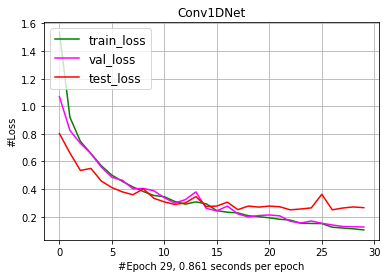

29	Training:
	Loss:	0.10427
	ACC:	0.96477
29	Validation:
	Loss:	0.12529
	val ACC:	0.95833
29	Testing:
	Loss:	0.05309
	test ACC:	0.92343




In [98]:
for epoch in range(num_epochs):
    train_loss = train_acc = train_batches = 0 
    train_acc_fixed = 0
    model.train()
    y_true,y_pred = [],[]
    start = time.time()
    for batch in train_loader:
        
        data,reference = batch
        data = data.transpose(2,1).to(device)
        
        print(data.shape)
        
        prediction = model(data)
        y_true.append(reference)
        y_pred.append(prediction)
        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        with torch.no_grad():
            train_loss += loss.item()
            train_batches += 1
    y_true = torch.cat(y_true,dim=0)
    y_pred = torch.cat(y_pred,dim=0)
    
    with torch.no_grad():
        train_acc += compute_acc(y_true, y_pred).cpu().numpy()
    
    val_loss = val_acc = val_batches = 0
    val_acc_fixed = 0
    #model.train(False)
    model.eval()
    y_true,y_pred = [],[]
    for batch in val_loader:
        data,reference = batch
        data = data.transpose(2,1).to(device)
        prediction = model(data)
        y_true.append(reference)
        y_pred.append(prediction)
        loss = compute_loss(reference, prediction)
        with torch.no_grad():
            val_loss += loss.item()
            
            val_batches += 1
    y_true = torch.cat(y_true,dim=0)
    y_pred = torch.cat(y_pred,dim=0)
    with torch.no_grad():
        val_acc += compute_acc(y_true, y_pred).cpu().numpy()
    #val_acc = (val_acc / val_batches)
    val_loss = (val_loss / val_batches)
    
    y_true,y_pred = [],[]
    test_loss = test_acc = test_batches = 0
    for batch in test_loader:
        data,reference = batch
        data = data.transpose(2,1).to(device)
        prediction = model(data)
        y_true.append(reference)
        y_pred.append(prediction)
        #print(len(reference),len(prediction))
        loss = compute_loss(reference, prediction)
        with torch.no_grad():
            test_loss += loss.item()
            
            test_batches += 1
    y_true = torch.cat(y_true,dim=0)
    y_pred = torch.cat(y_pred,dim=0)
    with torch.no_grad():
        test_acc += compute_acc(y_true, y_pred).cpu().numpy()
    #test_acc = (test_acc / test_batches)
    
    test_loss = (test_loss / test_batches)
    
    
    
    if val_loss < best_loss:
#         best_loss = val_loss
#         if sPATH != '' and os.path.exists(sPATH):
#             os.remove(sPATH)
        sPATH = drive_path + "saved_model.pth"
        #sPATH = fmt_str % (model.__class__.__name__,num_classes,best_loss)
        #sPATH = "/content/drive/My Drive/Colab Notebooks/dl_skt/project/skdl-sensors-har/" % (model.__class__.__name__,num_classes,best_loss)
        
        torch.save(model.state_dict(),sPATH)
        if best_acc > 94:
            print("Early Stopping")
            break
    report['train_loss'].append(train_loss / train_batches)
    report['val_loss'].append(val_loss)
    report['test_loss'].append(test_loss)
    finish = time.time()
    time_epoch = finish-start    
    display.clear_output(wait=True)
    fig = plt.Figure(figsize=(20,20),facecolor='white')
    plt.plot(report['train_loss'],color='green',label='train_loss')
    plt.plot(report['val_loss'],color='magenta',label='val_loss')
    plt.plot(report['test_loss'],color='red',label='test_loss')
    plt.xlabel("#Epoch %d, %.3f seconds per epoch" % (epoch,time_epoch))
    plt.ylabel("#Loss")
    plt.title(model.__class__.__name__)
    legend(loc=2, prop={'size': 12})
    plt.grid()
    plt.show()
    
    print("%d\tTraining:" % (epoch))
        
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tACC:\t%.5f" % (train_acc))
    print("%d\tValidation:" % (epoch))
#     print("\tBEST VAL loss:\t%.5f" % best_loss)
    print("\tLoss:\t%.5f" % val_loss)
    print("\tval ACC:\t%.5f" % val_acc)
    print("%d\tTesting:" % (epoch))
    print("\tLoss:\t%.5f" % (test_loss / test_batches))
    print("\ttest ACC:\t%.5f" % test_acc)
    print('\n')
    
    
    if epoch  % verbose == 0 or epoch == num_epochs - 1:
        pass

In [0]:
torch.save(model.state_dict(),"conv1d.pth")

In [68]:
%pwd

'/content/drive/My Drive/Colab Notebooks/dl_skt/project'

In [0]:
model.load_state_dict(torch.load(sPATH))
model.eval();

## Metrics

In [0]:
reference.shape,prediction.shape

In [0]:
y_true_np = torch.argmax(y_true,dim=-1).detach().cpu().numpy()
y_pred_np = torch.argmax(y_pred.log_softmax(dim=-1),dim=-1).detach().cpu().numpy()

In [0]:
np.unique(y_pred_np) == np.unique(y_true_np) 
assert len(y_true_np) == len(test_dataset)

In [0]:
n_conf = 5 if demo_mode else num_classes + 1

In [0]:
creport = pd.DataFrame((classification_report(y_true_np,y_pred_np,output_dict=True)))
acc = accuracy_score(y_true_np,y_pred_np)
fm_score = []
for i in range(n_conf):
    try:
        fm_score.append(creport[str(i)]['f1-score'])
    except:
        pass

In [0]:
np.mean(fm_score)

In [0]:
# rope jumping corrupting color scheme
cm  = create_conf_matrix(y_true_np,y_pred_np,n_classes=len(activities))
cmdf = pd.DataFrame(cm)
cmdf.columns = activities
cmdf.index = activities

In [0]:
cmdf

In [0]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.jet):
    """
        https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/48018785
    """
    plt.figure(figsize=(20,20),facecolor='white')
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title("%s" % (model.__class__.__name__))
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name, fontsize=12)
    plt.xlabel(df_confusion.columns.name, fontsize=12)

In [0]:
plot_confusion_matrix(cmdf)

In [0]:
print("%s\t%d\t%.4f\t%.4f" %(model.__class__.__name__,num_classes,np.mean(fm_score),acc))

## History of best Results (win_size = 256)

% model.__class__.__name__,num_classes,np.mean(fm_score),acc)
<br>
<br>
<pre>
Conv1DNet           12	0.8437	0.9380
MultiSincNet	    12	0.8635	0.9527
Conv1DLstmNet       12	0.9188	0.9318
MultiSincLstmNet	12	0.9219	0.9362
</pre>
<br>
<pre>
Conv1DNet	        4	0.9967	0.9960
MultiSincNet        4	0.9837	0.9855
Conv1DLstmNet	   4	0.9848	0.9868
MultiSincLstmNet	4	0.9934	0.9921
</pre>

## some inference

In [0]:
assert

In [0]:
def transform_csv(path):
    new_col_names = ["time", "hand_accelerometer", "hand_magnetometer", "hand_gyroscope", "ankle_accelerometer", "ankle_magnetometer", "ankle_gyroscope", "chest_accelerometer","chest_magnetometer", "chest_gyroscope"]
    replaced_cols = ["time", "hand_accelerometer", "hand_gyroscope", "hand_magnetometer", "ankle_accelerometer", "ankle_gyroscope","ankle_magnetometer",  "chest_accelerometer", "chest_gyroscope","chest_magnetometer"]
        
    def column_transform(data,col_name):
        if col_name != "time":
            new = data[col_name].str.replace(")","").str.replace("(","").str.replace(" ","").str.split(",", n = 2, expand = True) 
            data[col_name + "_x"] = new[0]
            data[col_name + "_y"] = new[1]
            data[col_name + "_z"] = new[2]
            data.drop(columns =[col_name], inplace = True) 
        return data
    
    data = pd.read_csv(path)
    
    data = data.rename(index=str,columns = dict(zip(list(data.columns),new_col_names)))
    
    data = data[replaced_cols]
    


    for col in data.columns:
        data = column_transform(data, col)
    return data

In [0]:
data = transform_csv('/ksozykinraid/src/real_run.csv')
data = data.drop(['time'],1)
data = data.values.astype('float32')

In [0]:
batch = []
for window in sliding_window(data,win_size=win_size,step=5):
    batch.append(window)
batch = torch.tensor(np.array(batch)).to(device)
batch = batch.transpose(2,1)

In [0]:
batch.shape

In [0]:
torch.argmax(model(batch).softmax(-1),-1)

In [0]:
[activities[int(e)] for e in torch.argmax(model(batch).softmax(-1),-1)]

## Visualisation  feature-maps after SincLayer

In [0]:
device = 'cuda'
fs = 100
model = MultiSincLstmNet(device=device).to(device)
sPATH = '/ksozykinraid/har-models/MultiSincLstmNet_12class_0.1178.pth'
model.load_state_dict(torch.load(sPATH))
model.eval();
N_filt=12

In [0]:
with torch.no_grad():
    params = torch.stack(list(model.sincconv.parameters())).cpu().numpy()
    filt_b1,filt_band = params*fs
    min_freq=1.0;
    min_band=10.0;
    filt_beg_freq=np.abs(filt_b1)+min_freq/fs
    filt_end_freq=filt_beg_freq+(np.abs(filt_band)+min_band/fs)

In [0]:
with torch.no_grad():
    sample_id = 0
    for viz_batch  in test_loader:
        viz_data,reference = viz_batch
        viz_data = viz_data.transpose(2,1).to(device)
        viz_sinc = model.sincconv(viz_data).cpu().numpy()[sample_id]
        viz_data = viz_data.cpu().numpy()[sample_id]
        viz_sinc = viz_sinc.reshape([N_filt,input_channels,-1]).transpose(1,0,2)
        break

In [0]:
"""
https://stackoverflow.com/a/38251497
https://stackoverflow.com/a/28222930
"""
from itertools import cycle
cycol = cycle('bgrcmk')

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [0]:
with torch.no_grad():
    k =  10## channel_id
    n_viz_samples  = 128
    figure(facecolor='white',figsize=(25,25))
    for i in range(N_filt+1):
        plt.subplot(4,4,i+1)
        if i == 0:
            plot(viz_data[k][:n_viz_samples],color='green')
            title(subjects[0].columns[k-1])
        else:
            title("%s, \n %d channel" %(subjects[0].columns[k-1],i-1))
            plot(viz_sinc[k][i-1][:n_viz_samples],color=next(cycol))
            

In [0]:
from PIL import Image

import numpy as np
import torch
from torch.autograd import Function


def set_requires_grad(model, requires_grad=True):
    for param in model.parameters():
        param.requires_grad = requires_grad


def loop_iterable(iterable):
    while True:
        yield from iterable


class GrayscaleToRgb:
    """Convert a grayscale image to rgb"""
    def __call__(self, image):
        image = np.array(image)
        image = np.dstack([image, image, image])
        return Image.fromarray(image)


class GradientReversalFunction(Function):
    """
    Gradient Reversal Layer from:
    Unsupervised Domain Adaptation by Backpropagation (Ganin & Lempitsky, 2015)

    Forward pass is the identity function. In the backward pass,
    the upstream gradients are multiplied by -lambda (i.e. gradient is reversed)
    """

    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.clone()

    @staticmethod
    def backward(ctx, grads):
        lambda_ = ctx.lambda_
        lambda_ = grads.new_tensor(lambda_)
        dx = -lambda_ * grads
        return dx, None


class GradientReversal(torch.nn.Module):
    def __init__(self, lambda_=1):
        super(GradientReversal, self).__init__()
        self.lambda_ = lambda_

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)

In [40]:
train_dataset_targ = pamap2Dataset (list0,
                               fold='train',
                               num_classes=num_classes,
                               useful_columns = useful_columns_,
                               win_size=win_size,step=step)

val_dataset_targ = pamap2Dataset (list0,
                             fold='val',
                             num_classes=num_classes,
                             useful_columns = useful_columns_,
                             win_size=win_size)

test_dataset_targ = pamap2Dataset (list0,
                              fold='test',
                              num_classes=num_classes,
                              useful_columns = useful_columns_,
                              test_subject = 6,
                              win_size=win_size,
                              step=step)
train_dataset_s = pamap2Dataset (subjects,
                               fold='train',
                               num_classes=num_classes,
                               useful_columns = useful_columns_,
                               win_size=win_size,step=step)

  0%|          | 0/9 [00:00<?, ?it/s]

useful columns:
['hand_acc_16g_x', 'hand_acc_16g_y', 'hand_acc_16g_z', 'hand_gyroscope_x', 'hand_gyroscope_y', 'hand_gyroscope_z', 'hand_magnometer_x', 'hand_magnometer_y', 'hand_magnometer_z', 'activityID']


  0%|          | 0/9 [00:00<?, ?it/s]

useful columns:
['hand_acc_16g_x', 'hand_acc_16g_y', 'hand_acc_16g_z', 'hand_gyroscope_x', 'hand_gyroscope_y', 'hand_gyroscope_z', 'hand_magnometer_x', 'hand_magnometer_y', 'hand_magnometer_z', 'activityID']


  0%|          | 0/9 [00:00<?, ?it/s]

useful columns:
['hand_acc_16g_x', 'hand_acc_16g_y', 'hand_acc_16g_z', 'hand_gyroscope_x', 'hand_gyroscope_y', 'hand_gyroscope_z', 'hand_magnometer_x', 'hand_magnometer_y', 'hand_magnometer_z', 'activityID']


  0%|          | 0/9 [00:00<?, ?it/s]

useful columns:
['hand_acc_16g_x', 'hand_acc_16g_y', 'hand_acc_16g_z', 'hand_gyroscope_x', 'hand_gyroscope_y', 'hand_gyroscope_z', 'hand_magnometer_x', 'hand_magnometer_y', 'hand_magnometer_z', 'activityID']


100%|██████████| 9/9 [00:49<00:00,  4.43s/it]


In [113]:
# """
# Implements ADDA:
# Adversarial Discriminative Domain Adaptation, Tzeng et al. (2017)
# """
# import argparse

import torch
from torch import nn
from torch.utils.data import DataLoader
#from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor
from tqdm import tqdm, trange

#import config
#from data import MNISTM
#from models import Net
#from utils import loop_iterable, set_requires_grad, GrayscaleToRgb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def main(model_file, batch_size, iterations, epochs, k_disc, k_clf):
#     print("test1")
    source_model = Conv1DNet().to(device)
    
    source_model.load_state_dict(torch.load(model_file))
    
    state_dict = torch.load(model_file)
    
    # create new OrderedDict that does not contain `module.`
#     from collections import OrderedDict
#     new_state_dict = OrderedDict()
    
#     for k, v in state_dict.items():
#         name = k[7:] # remove `module.`
#         new_state_dict[name] = v
    
#     #load params
#     source_model.load_state_dict(new_state_dict)
    
    source_model.eval()
    set_requires_grad(source_model, requires_grad=False)
    
    clf = source_model
    source_model = source_model.features

    target_model = Conv1DNet().to(device)
    target_model.load_state_dict(torch.load(model_file))
    target_model = target_model.features

    discriminator = nn.Sequential(
          GradientReversal(),
          model.fc1,
          nn.ReLU(),
          model.fc2,
          nn.ReLU(),
          nn.Linear(512,1)
    ).to(device)

    half_batch = batch_size // 2


#     source_dataset = pamap2Dataset(subjects,fold='train',num_classes=num_classes, useful_columns = useful_columns_,win_size=win_size,step=step)
#     source_loader  = torch.utils.data.DataLoader(train_dataset_s,batch_size=batch_size,shuffle=True)

#     train_dataset = pamap2Dataset (list0,
#                                fold='train',
#                                num_classes=num_classes,
#                                useful_columns = useful_columns_,
#                                win_size=win_size,step=step)
    
#     target_loader  = torch.utils.data.DataLoader(train_dataset_targ,batch_size=batch_size,shuffle=True)
    
    discriminator_optim = torch.optim.Adam(discriminator.parameters())
    target_optim = torch.optim.Adam(target_model.parameters())
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(1, epochs+1):
#         print("test2")
        batch_iterator = zip(loop_iterable(source_loader), loop_iterable(target_loader))
#         print("test3")
        total_loss = 0
        total_accuracy = 0
        for _ in trange(iterations, leave=False):
            # Train discriminator
            
#             print ("test", epoch)
            
            set_requires_grad(target_model, requires_grad=False)
            set_requires_grad(discriminator, requires_grad=True)
            for _ in range(k_disc):
#                 print(_)
                (source_x, _), (target_x, _) = next(batch_iterator)
                source_x, target_x = source_x.transpose(2,1).to(device), target_x.transpose(2,1).to(device)
#                 print ("test_01", source_x.shape, target_x.shape)
                source_features = source_model(source_x).view(source_x.shape[0], -1)
#                 print("helb", source_features.shape)
                target_features = target_model(target_x).view(target_x.shape[0], -1)
#                 print("helb", target_features.shape)

                discriminator_x = torch.cat([source_features, target_features])
                discriminator_y = torch.cat([torch.ones(source_x.shape[0], device=device),
                                             torch.zeros(target_x.shape[0], device=device)])

                preds = discriminator(discriminator_x).squeeze()
#                 print(preds.shape)
#                 print(discriminator_y.shape)
                loss = criterion(preds, discriminator_y)

                discriminator_optim.zero_grad()
                loss.backward()
                discriminator_optim.step()

                total_loss += loss.item()
                total_accuracy += ((preds > 0).long() == discriminator_y.long()).float().mean().item()

            # Train classifier
            set_requires_grad(target_model, requires_grad=True)
            set_requires_grad(discriminator, requires_grad=False)
            for _ in range(k_clf):
                _, (target_x, _) = next(batch_iterator)
                target_x = target_x.transpose(2,1).to(device)
#                 target_x = torch.argmax(target_x, dim=-1)
                target_features = target_model(target_x).view(target_x.shape[0], -1)

                # flipped labels
                discriminator_y = torch.ones(target_x.shape[0], device=device)

                preds = discriminator(target_features).squeeze()
                loss = criterion(preds, discriminator_y)

                target_optim.zero_grad()
                loss.backward()
                target_optim.step()

        mean_loss = total_loss / (iterations*k_disc)
        mean_accuracy = total_accuracy / (iterations*k_disc)
        tqdm.write(f'EPOCH {epoch:03d}: discriminator_loss={mean_loss:.4f}, '
                   f'discriminator_accuracy={mean_accuracy:.4f}', nolock=True)

        # Create the full target model and save it
        clf.features = target_model
        torch.save(clf.state_dict(), drive_path + 'adda.pth')


if __name__ == '__main__':
    #arg_parser = argparse.ArgumentParser(description='Domain adaptation using ADDA')
    #arg_parser.add_argument('MODEL_FILE', help='A model in trained_models')
    #arg_parser.add_argument('--batch-size', type=int, default=64)
    #arg_parser.add_argument('--iterations', type=int, default=500)
    #arg_parser.add_argument('--epochs', type=int, default=5)
    #arg_parser.add_argument('--k-disc', type=int, default=1)
    #arg_parser.add_argument('--k-clf', type=int, default=10)
    #args = arg_parser.parse_args()
    
    #model_file = drive_path + "saved_model.pth"
    
    model_path = "/content/drive/My Drive/Colab Notebooks/dl_skt/project/"
    model_file = model_path + "conv1d.pth"

    batch_size = 64
    iterations = 500
    epochs     = 5
    k_disc     = 1
    k_clf      = 10
    
    main (model_file, batch_size, iterations, epochs, k_disc, k_clf)

  1%|          | 3/500 [00:00<00:23, 20.99it/s]

EPOCH 001: discriminator_loss=0.0239, discriminator_accuracy=0.9967


  1%|          | 3/500 [00:00<00:26, 18.81it/s]

EPOCH 002: discriminator_loss=0.0000, discriminator_accuracy=1.0000


 59%|█████▊    | 293/500 [00:14<00:10, 20.41it/s]

KeyboardInterrupt: ignored

In [0]:

#source_dataset = pamap2Dataset(subjects,fold='train',num_classes=num_classes, useful_columns = useful_columns_,win_size=win_size,step=step)
source_loader  = torch.utils.data.DataLoader(train_dataset_s,batch_size=batch_size,shuffle=True)


#target_dataset = pamap2Dataset(subjects,fold='train',num_classes=num_classes,win_size=win_size,step=step)
#target_loader  = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

#train_dataset = pamap2Dataset (list0,
#                           fold='train',
#                           num_classes=num_classes,
#                           useful_columns = useful_columns_,
#                           win_size=win_size,step=step)

target_loader  = torch.utils.data.DataLoader(train_dataset_targ,batch_size=batch_size,shuffle=True)


In [0]:
#print (set (list0 [:] ['activityID']))

print (set (list0 [0] ['activityID'] +
       list0 [1] ['activityID'] +
       list0 [2] ['activityID'] +
       list0 [3] ['activityID'] +
       list0 [4] ['activityID'] +
       list0 [5] ['activityID'] +
       list0 [6] ['activityID'] +
       list0 [7] ['activityID'] +
       list0 [8] ['activityID']))

#print (subjects)

In [1]:
list0

NameError: ignored

In [46]:
"""
Implements RevGrad:
Unsupervised Domain Adaptation by Backpropagation, Ganin & Lemptsky (2014)
Domain-adversarial training of neural networks, Ganin et al. (2016)
"""
# import argparse

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor
from tqdm import tqdm

import config
# from data import MNISTM
# # from models import Net
# from utils import GrayscaleToRgb, GradientReversal


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def main(model_file, batch_size, epochs):
    model = Conv1DNet().to(device)
    model.load_state_dict(torch.load(model_file))
    feature_extractor = model.features
    clf = model.classifier

    discriminator = nn.Sequential(
          GradientReversal(),
          model.fc1,
          nn.ReLU(),
          model.fc2,
          nn.ReLU(),
          nn.Linear(512,1)
    ).to(device)

    half_batch = batch_size // 2
#     source_dataset = MNIST(config.DATA_DIR/'mnist', train=True, download=True,
#                           transform=Compose([GrayscaleToRgb(), ToTensor()]))
#     source_loader = DataLoader(source_dataset, batch_size=half_batch,
#                                shuffle=True, num_workers=1, pin_memory=True)
    
#     target_dataset = MNISTM(train=False)
#     target_loader = DataLoader(target_dataset, batch_size=half_batch,
#                                shuffle=True, num_workers=1, pin_memory=True)

    #source_dataset = pamap2Dataset(subjects,fold='train',num_classes=num_classes,win_size=win_size,step=step)
    #source_loader  = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
    
#     source_dataset = pamap2Dataset(subjects,fold='train',num_classes=num_classes, useful_columns = useful_columns_,win_size=win_size,step=step)
#     source_loader  = torch.utils.data.DataLoader(train_dataset_s,batch_size=batch_size,shuffle=True)


#     #target_dataset = pamap2Dataset(subjects,fold='train',num_classes=num_classes,win_size=win_size,step=step)
#     #target_loader  = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
    
#     train_dataset = pamap2Dataset (list0,
#                                fold='train',
#                                num_classes=num_classes,
#                                useful_columns = useful_columns_,
#                                win_size=win_size,step=step)
    
#     target_loader  = torch.utils.data.DataLoader(train_dataset_targ,batch_size=batch_size,shuffle=True)

    optim = torch.optim.Adam(list(discriminator.parameters()) + list(model.parameters()))

    for epoch in range(1, epochs+1):
        batches = zip(source_loader, target_loader)
        n_batches = min(len(source_loader), len(target_loader))

        total_domain_loss = total_label_accuracy = total_target_accuracy = 0
        for (source_x, source_labels), (target_x, _) in tqdm(batches, leave=False, total=n_batches):
                #print (source_labels)
                #print (_)
                
                x = torch.cat([source_x.transpose(2,1), target_x.transpose(2,1)])
                x = x.to(device)
                domain_y = torch.cat([torch.ones(source_x.shape[0]),
                                      torch.zeros(target_x.shape[0])])
                domain_y = domain_y.to(device)
                label_y = source_labels.to(device)
                label_y_targ = _.to(device)                
                
                features = feature_extractor(x).view(x.shape[0], -1)
                domain_preds = discriminator(features).squeeze()
                label_preds = clf(features[:source_x.shape[0]])
                label_preds_targ = clf(features[:target_x.shape[0]])
                
#                 print(domain_preds.shape,domain_y.shape)

                domain_loss = F.binary_cross_entropy_with_logits(domain_preds, domain_y)
                label_y = torch.argmax(label_y,dim=-1)
                
                label_loss = F.cross_entropy(label_preds, label_y.to(torch.long))
                label_y_targ = torch.argmax(label_y_targ,dim=-1)
#                 label_loss_targ = F.cross_entropy(label_preds_targ, label_y_targ.to(torch.long))
                
                loss = domain_loss + label_loss

                optim.zero_grad()
                
                loss.backward()
                
                optim.step()

                total_domain_loss += domain_loss.item()
                total_label_accuracy += (label_preds.max(1)[1] == label_y).float().mean().item()
              
              
                total_target_accuracy += (label_preds_targ.max(1)[1] == label_y_targ).float().mean().item()

        mean_loss = total_domain_loss / n_batches
        mean_accuracy = total_label_accuracy / n_batches
        target_accuracy = total_target_accuracy / n_batches
        tqdm.write(f'EPOCH {epoch:03d}: domain_loss={mean_loss:.4f}, '
                   f'source_accuracy={mean_accuracy:.4f},'
                   f'target_accuracy={target_accuracy:.4f}')

        torch.save(model.state_dict(), drive_path + 'revgrad.pth')
        
if __name__ == '__main__':
#     arg_parser = argparse.ArgumentParser(description='Domain adaptation using RevGrad')
#     arg_parser.add_argument('MODEL_FILE', help='A model in trained_models')
#     arg_parser.add_argument('--batch-size', type=int, default=64)
#     arg_parser.add_argument('--epochs', type=int, default=15)
#     args = arg_parser.parse_args()
    
    #model_file = drive_path + "saved_model.pth"
    model_path = "/content/drive/My Drive/Colab Notebooks/dl_skt/project/"
    
    #model_file = drive_path + "conv1d.pth"
    model_file = model_path + "conv1d.pth"
    
    batch_size = 64
    epochs     = 20

    main(model_file, batch_size, epochs)
    
    
#         model_file = "/content/drive/My Drive/Colab Notebooks/dl_skt/project/saved_model.pth"
#     batch_size = 64
#     iterations = 500
#     epochs     = 5
#     k_disc     = 1
#     k_clf      = 10
    
#     main (model_file, batch_size, iterations, epochs, k_disc, k_clf)

EPOCH 001: domain_loss=0.3051, source_accuracy=0.8229,target_accuracy=0.1100


 10%|▉         | 14/147 [00:00<00:01, 130.17it/s]

EPOCH 002: domain_loss=0.3650, source_accuracy=0.8329,target_accuracy=0.1144


 10%|▉         | 14/147 [00:00<00:00, 133.70it/s]

EPOCH 003: domain_loss=0.4085, source_accuracy=0.8490,target_accuracy=0.1039


 10%|▉         | 14/147 [00:00<00:00, 133.70it/s]

EPOCH 004: domain_loss=0.3833, source_accuracy=0.8564,target_accuracy=0.1084


  9%|▉         | 13/147 [00:00<00:01, 123.04it/s]

EPOCH 005: domain_loss=0.4705, source_accuracy=0.8542,target_accuracy=0.1091


 10%|▉         | 14/147 [00:00<00:01, 132.62it/s]

EPOCH 006: domain_loss=0.4863, source_accuracy=0.8577,target_accuracy=0.1151


 10%|▉         | 14/147 [00:00<00:01, 131.76it/s]

EPOCH 007: domain_loss=0.4725, source_accuracy=0.8548,target_accuracy=0.1125


  8%|▊         | 12/147 [00:00<00:01, 119.29it/s]

EPOCH 008: domain_loss=0.4820, source_accuracy=0.8652,target_accuracy=0.1125


 10%|▉         | 14/147 [00:00<00:01, 132.16it/s]

EPOCH 009: domain_loss=0.4865, source_accuracy=0.8697,target_accuracy=0.1138


 10%|▉         | 14/147 [00:00<00:00, 135.86it/s]

EPOCH 010: domain_loss=0.5276, source_accuracy=0.8671,target_accuracy=0.1116


 10%|▉         | 14/147 [00:00<00:00, 136.09it/s]

EPOCH 011: domain_loss=0.5069, source_accuracy=0.8784,target_accuracy=0.1072


 10%|▉         | 14/147 [00:00<00:00, 135.28it/s]

EPOCH 012: domain_loss=0.5099, source_accuracy=0.8798,target_accuracy=0.1100


 10%|▉         | 14/147 [00:00<00:00, 135.32it/s]

EPOCH 013: domain_loss=0.5095, source_accuracy=0.8863,target_accuracy=0.1105


  8%|▊         | 12/147 [00:00<00:01, 112.34it/s]

EPOCH 014: domain_loss=0.5329, source_accuracy=0.8825,target_accuracy=0.1188


  9%|▉         | 13/147 [00:00<00:01, 126.14it/s]

EPOCH 015: domain_loss=0.5063, source_accuracy=0.8881,target_accuracy=0.1069


  9%|▉         | 13/147 [00:00<00:01, 123.49it/s]

EPOCH 016: domain_loss=0.5203, source_accuracy=0.8919,target_accuracy=0.1106


  9%|▉         | 13/147 [00:00<00:01, 127.71it/s]

EPOCH 017: domain_loss=0.5175, source_accuracy=0.8971,target_accuracy=0.1053


  9%|▉         | 13/147 [00:00<00:01, 120.82it/s]

EPOCH 018: domain_loss=0.5207, source_accuracy=0.8931,target_accuracy=0.1128


  9%|▉         | 13/147 [00:00<00:01, 122.04it/s]

EPOCH 019: domain_loss=0.5352, source_accuracy=0.8953,target_accuracy=0.1107


EPOCH 020: domain_loss=0.5381, source_accuracy=0.8970,target_accuracy=0.1077


In [0]:
20%|█▉        | 29/147 [00:00<00:00, 288.09it/s]EPOCH 001: domain_loss=0.7877, source_accuracy=0.6827,target_accuracy=0.1132
 20%|█▉        | 29/147 [00:00<00:00, 281.40it/s]EPOCH 002: domain_loss=0.7874, source_accuracy=0.6791,target_accuracy=0.1122
 19%|█▉        | 28/147 [00:00<00:00, 272.51it/s]EPOCH 003: domain_loss=0.7867, source_accuracy=0.6808,target_accuracy=0.1127
 20%|█▉        | 29/147 [00:00<00:00, 283.50it/s]EPOCH 004: domain_loss=0.7847, source_accuracy=0.6826,target_accuracy=0.1129
 20%|█▉        | 29/147 [00:00<00:00, 282.43it/s]EPOCH 005: domain_loss=0.7831, source_accuracy=0.6847,target_accuracy=0.1135
 20%|█▉        | 29/147 [00:00<00:00, 283.54it/s]EPOCH 006: domain_loss=0.7868, source_accuracy=0.6808,target_accuracy=0.1120
 20%|█▉        | 29/147 [00:00<00:00, 286.50it/s]EPOCH 007: domain_loss=0.7882, source_accuracy=0.6825,target_accuracy=0.1089
 20%|█▉        | 29/147 [00:00<00:00, 283.07it/s]EPOCH 008: domain_loss=0.7886, source_accuracy=0.6755,target_accuracy=0.1109
 18%|█▊        | 26/147 [00:00<00:00, 257.30it/s]EPOCH 009: domain_loss=0.7857, source_accuracy=0.6840,target_accuracy=0.1127
 20%|█▉        | 29/147 [00:00<00:00, 288.54it/s]EPOCH 010: domain_loss=0.7849, source_accuracy=0.6760,target_accuracy=0.1094
 20%|█▉        | 29/147 [00:00<00:00, 287.57it/s]EPOCH 011: domain_loss=0.7890, source_accuracy=0.6760,target_accuracy=0.1065
 20%|█▉        | 29/147 [00:00<00:00, 284.40it/s]EPOCH 012: domain_loss=0.7861, source_accuracy=0.6786,target_accuracy=0.1174
 20%|█▉        | 29/147 [00:00<00:00, 287.25it/s]EPOCH 013: domain_loss=0.7829, source_accuracy=0.6861,target_accuracy=0.1104
 20%|█▉        | 29/147 [00:00<00:00, 285.90it/s]EPOCH 014: domain_loss=0.7900, source_accuracy=0.6809,target_accuracy=0.1055
                                                  EPOCH 015: domain_loss=0.7844, source_accuracy=0.6843,target_accuracy=0.1109
      
      8%|▊         | 12/147 [00:00<00:01, 116.59it/s]EPOCH 001: domain_loss=0.1088, source_accuracy=0.9465,target_accuracy=0.1021
  9%|▉         | 13/147 [00:00<00:01, 121.25it/s]EPOCH 002: domain_loss=0.1015, source_accuracy=0.9600,target_accuracy=0.1089
  9%|▉         | 13/147 [00:00<00:01, 120.66it/s]EPOCH 003: domain_loss=0.1143, source_accuracy=0.9597,target_accuracy=0.1057
  8%|▊         | 12/147 [00:00<00:01, 110.54it/s]EPOCH 004: domain_loss=0.1416, source_accuracy=0.9635,target_accuracy=0.1050
  9%|▉         | 13/147 [00:00<00:01, 121.30it/s]EPOCH 005: domain_loss=0.1800, source_accuracy=0.9629,target_accuracy=0.1061
  8%|▊         | 12/147 [00:00<00:01, 119.45it/s]EPOCH 006: domain_loss=0.1721, source_accuracy=0.9626,target_accuracy=0.1060
  9%|▉         | 13/147 [00:00<00:01, 120.69it/s]EPOCH 007: domain_loss=0.1906, source_accuracy=0.9662,target_accuracy=0.1033
  8%|▊         | 12/147 [00:00<00:01, 113.77it/s]EPOCH 008: domain_loss=0.1893, source_accuracy=0.9673,target_accuracy=0.1033
  8%|▊         | 12/147 [00:00<00:01, 119.43it/s]EPOCH 009: domain_loss=0.1858, source_accuracy=0.9625,target_accuracy=0.1085
 10%|▉         | 14/147 [00:00<00:00, 139.34it/s]EPOCH 010: domain_loss=0.2049, source_accuracy=0.9713,target_accuracy=0.1122
 10%|█         | 15/147 [00:00<00:00, 140.96it/s]EPOCH 011: domain_loss=0.1915, source_accuracy=0.9737,target_accuracy=0.1058
 10%|▉         | 14/147 [00:00<00:00, 136.69it/s]EPOCH 012: domain_loss=0.1884, source_accuracy=0.9733,target_accuracy=0.1046
 10%|▉         | 14/147 [00:00<00:00, 138.32it/s]EPOCH 013: domain_loss=0.1988, source_accuracy=0.9725,target_accuracy=0.1074
 10%|▉         | 14/147 [00:00<00:00, 139.97it/s]EPOCH 014: domain_loss=0.2062, source_accuracy=0.9703,target_accuracy=0.1046
                                                  EPOCH 015: domain_loss=0.2164, source_accuracy=0.9670,target_accuracy=0.1010

In [0]:
"""
Implements WDGRL:
Wasserstein Distance Guided Representation Learning, Shen et al. (2017)
"""
import argparse

import torch
from torch import nn
from torch.autograd import grad
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor
from tqdm import tqdm, trange

import config
# from utils import loop_iterable, set_requires_grad, GrayscaleToRgb


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def gradient_penalty(critic, h_s, h_t):
    # based on: https://github.com/caogang/wgan-gp/blob/master/gan_cifar10.py#L116
    alpha = torch.rand(h_s.size(0), 1).to(device)
    differences = h_t - h_s
    interpolates = h_s + (alpha * differences)
    interpolates = torch.stack([interpolates, h_s, h_t]).requires_grad_()

    preds = critic(interpolates)
    gradients = grad(preds, interpolates,
                     grad_outputs=torch.ones_like(preds),
                     retain_graph=True, create_graph=True)[0]
    gradient_norm = gradients.norm(2, dim=1)
    gradient_penalty = ((gradient_norm - 1)**2).mean()
    return gradient_penalty


def main(model_file, batch_size, iterations, epochs, k_critics, k_clf, gamma, wd_clf):
    clf_model = Conv1DNet().to(device)
    clf_model.load_state_dict(torch.load(model_file))
    
    feature_extractor = clf_model.features
    discriminator = clf_model.classifier

    critic = nn.Sequential(
          GradientReversal(),
          model.fc1,
          nn.ReLU(),
          model.fc2,
          nn.ReLU(),
          nn.Linear(512,1)
    ).to(device)

    half_batch = batch_size // 2

#     #source_dataset = pamap2Dataset(subjects,fold='train',num_classes=num_classes,win_size=win_size,step=step)
#     #source_loader  = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
    
#     source_dataset = pamap2Dataset(subjects,fold='train',num_classes=num_classes, useful_columns = useful_columns_,win_size=win_size,step=step)
#     source_loader  = torch.utils.data.DataLoader(train_dataset_s,batch_size=batch_size,shuffle=True)

#     #target_dataset = pamap2Dataset(DaS_dataframe,fold='train',num_classes=num_classes,win_size=win_size,step=step)
#     #target_loader  = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
    
#     train_dataset = pamap2Dataset (list0,
#                                fold='train',
#                                num_classes=num_classes,
#                                useful_columns = useful_columns_,
#                                win_size=win_size,step=step)
    
#     target_loader  = torch.utils.data.DataLoader(train_dataset_targ,batch_size=batch_size,shuffle=True)
    
    critic_optim = torch.optim.Adam(critic.parameters(), lr=1e-4)
    clf_optim = torch.optim.Adam(clf_model.parameters(), lr=1e-4)
    clf_criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs+1):
        batch_iterator = zip(loop_iterable(source_loader), loop_iterable(target_loader))

        total_loss = 0
        total_accuracy = 0
        for _ in trange(iterations, leave=False):
            (source_x, source_y), (target_x, _) = next(batch_iterator)
            # Train critic
            set_requires_grad(feature_extractor, requires_grad=False)
            set_requires_grad(critic, requires_grad=True)

            source_x, target_x = source_x.transpose(2,1).to(device), target_x.transpose(2,1).to(device)
            source_y = source_y.to(device)

            with torch.no_grad():
                h_s = feature_extractor(source_x).data.view(source_x.shape[0], -1)
                h_t = feature_extractor(target_x).data.view(target_x.shape[0], -1)
            for _ in range(k_critic):
                gp = gradient_penalty(critic, h_s, h_t)

                critic_s = critic(h_s)
                critic_t = critic(h_t)
                wasserstein_distance = critic_s.mean() - critic_t.mean()

                critic_cost = -wasserstein_distance + gamma*gp

                critic_optim.zero_grad()
                critic_cost.backward()
                critic_optim.step()

                total_loss += critic_cost.item()

            # Train classifier
            set_requires_grad(feature_extractor, requires_grad=True)
            set_requires_grad(critic, requires_grad=False)
            for _ in range(k_clf):
                source_features = feature_extractor(source_x).view(source_x.shape[0], -1)
                target_features = feature_extractor(target_x).view(target_x.shape[0], -1)

                source_preds = discriminator(source_features)
                source_y = torch.argmax(source_y, dim=-1)
                clf_loss = clf_criterion(source_preds, source_y.to(torch.long))
                wasserstein_distance = critic(source_features).mean() - critic(target_features).mean()

                loss = clf_loss + wd_clf * wasserstein_distance
                clf_optim.zero_grad()
                loss.backward()
                clf_optim.step()

        mean_loss = total_loss / (iterations * k_critic)
        tqdm.write(f'EPOCH {epoch:03d}: critic_loss={mean_loss:.4f}')
        torch.save(clf_model.state_dict(), drive_path + 'wdgrl.pth')


if __name__ == '__main__':
#     arg_parser = argparse.ArgumentParser(description='Domain adaptation using WDGRL')
#     arg_parser.add_argument('MODEL_FILE', help='A model in trained_models')
#     arg_parser.add_argument('--batch-size', type=int, default=64)
#     arg_parser.add_argument('--iterations', type=int, default=500)
#     arg_parser.add_argument('--epochs', type=int, default=5)
#     arg_parser.add_argument('--k-critic', type=int, default=5)
#     arg_parser.add_argument('--k-clf', type=int, default=1)
#     arg_parser.add_argument('--gamma', type=float, default=10)
#     arg_parser.add_argument('--wd-clf', type=float, default=1)
#     args = arg_parser.parse_args()
    model_file = drive_path + "saved_model.pth"
    batch_size = 64
    iterations = 500 
    epochs = 5 
    k_critic = 5 
    k_clf = 1
    gamma = 10 
    wd_clf = 1
    main(model_file, batch_size, iterations, epochs, k_critic, k_clf, gamma, wd_clf)
    
# if __name__ == '__main__':
#     #arg_parser = argparse.ArgumentParser(description='Domain adaptation using ADDA')
#     #arg_parser.add_argument('MODEL_FILE', help='A model in trained_models')
#     #arg_parser.add_argument('--batch-size', type=int, default=64)
#     #arg_parser.add_argument('--iterations', type=int, default=500)
#     #arg_parser.add_argument('--epochs', type=int, default=5)
#     #arg_parser.add_argument('--k-disc', type=int, default=1)
#     #arg_parser.add_argument('--k-clf', type=int, default=10)
#     #args = arg_parser.parse_args()
    
#     model_file = "/content/drive/My Drive/Colab Notebooks/dl_skt/project/saved_model.pth"
#     batch_size = 64
#     iterations = 500
#     epochs     = 5
#     k_disc     = 1
#     k_clf      = 10
    
#     main (model_file, batch_size, iterations, epochs, k_disc, k_clf)



  0%|          | 0/9 [00:00<?, ?it/s]

useful columns:
['hand_acc_16g_x', 'hand_acc_16g_y', 'hand_acc_16g_z', 'hand_gyroscope_x', 'hand_gyroscope_y', 'hand_gyroscope_z', 'hand_magnometer_x', 'hand_magnometer_y', 'hand_magnometer_z', 'activityID']




 11%|█         | 1/9 [00:08<01:11,  8.97s/it]

 22%|██▏       | 2/9 [00:18<01:04,  9.18s/it]

 33%|███▎      | 3/9 [00:24<00:49,  8.28s/it]

 44%|████▍     | 4/9 [00:33<00:41,  8.32s/it]

 56%|█████▌    | 5/9 [00:43<00:35,  8.79s/it]

 67%|██████▋   | 6/9 [00:51<00:26,  8.80s/it]

 78%|███████▊  | 7/9 [01:00<00:17,  8.74s/it]

 89%|████████▉ | 8/9 [01:10<00:08,  8.97s/it]

100%|██████████| 9/9 [01:10<00:00,  6.35s/it]



  0%|          | 0/9 [00:00<?, ?it/s]

useful columns:
['hand_acc_16g_x', 'hand_acc_16g_y', 'hand_acc_16g_z', 'hand_gyroscope_x', 'hand_gyroscope_y', 'hand_gyroscope_z', 'hand_magnometer_x', 'hand_magnometer_y', 'hand_magnometer_z', 'activityID']




 11%|█         | 1/9 [00:01<00:14,  1.82s/it]

 22%|██▏       | 2/9 [00:03<00:12,  1.84s/it]

 33%|███▎      | 3/9 [00:05<00:10,  1.82s/it]

 44%|████▍     | 4/9 [00:07<00:09,  1.81s/it]

 56%|█████▌    | 5/9 [00:09<00:07,  1.79s/it]

 67%|██████▋   | 6/9 [00:10<00:05,  1.83s/it]

 78%|███████▊  | 7/9 [00:12<00:03,  1.81s/it]

 89%|████████▉ | 8/9 [00:14<00:01,  1.80s/it]

100%|██████████| 9/9 [00:17<00:00,  2.15s/it]



  0%|          | 0/500 [00:00<?, ?it/s]

  1%|          | 3/500 [00:00<00:19, 24.94it/s]

  1%|          | 6/500 [00:00<00:19, 25.42it/s]

  2%|▏         | 9/500 [00:00<00:19, 25.81it/s]

  3%|▎         | 13/500 [00:00<00:17, 27.22it/s]

  3%|▎         | 17/500 [00:00<00:16, 28.50it/s]

  4%|▍         | 21/500 [00:00<00:16, 29.65it/s]

  5%|▌         | 25/500 [00:00<00:15, 30.49it/s]

  6%|▌         | 29/500 [00:00<00:15, 30.98it/s]

  7%|▋         | 33/500 [00:01<00:14, 31.43it/s]

  7%|▋         | 37/500 [00:01<00:14, 31.86it/s]

  8%|▊         | 41/500 [00:01<00:1

RuntimeError: ignored

In [0]:
# def transform_csv(path):
#     new_col_names = ["time", "hand_accelerometer", "hand_magnetometer", "hand_gyroscope", "ankle_accelerometer", "ankle_magnetometer", "ankle_gyroscope", "chest_accelerometer","chest_magnetometer", "chest_gyroscope"]
#     replaced_cols = ["time", "hand_accelerometer", "hand_gyroscope", "hand_magnetometer", "ankle_accelerometer", "ankle_gyroscope","ankle_magnetometer",  "chest_accelerometer", "chest_gyroscope","chest_magnetometer"]
        
#     def column_transform(data,col_name):
#         if col_name != "time":
#             new = data[col_name].str.replace(")","").str.replace("(","").str.replace(" ","").str.split(",", n = 2, expand = True) 
#             data[col_name + "_x"] = new[0]
#             data[col_name + "_y"] = new[1]
#             data[col_name + "_z"] = new[2]
#             data.drop(columns =[col_name], inplace = True) 
#         return data
    
#     data = pd.read_csv(path)
    
#     data = data.rename(index=str,columns = dict(zip(list(data.columns),new_col_names)))
    
#     data = data[replaced_cols]
    


#     for col in data.columns:
#         data = column_transform(data, col)
#     return data

In [0]:
# data = transform_csv('/content/drive/My Drive/Colab Notebooks/dl_skt/project/skdl-sensors-har/data1hand.csv')
# data = data.iloc[:,:len(data_columns_onehand)+1]
# data = data.drop(['time'],1)
# data = data.values.astype('float32')

In [0]:
# data.shape

In [0]:
def run_adaptation (model, dataset1, dataset2, method, epochs, optimizer):
    #pupa
    #lupa
    print ("shtosh")

#revgrad на mnist
#conv1d на pamap
#conv1d на das
#revgrad на pamap -> das
#revgrad на das -> pamap